## Detector energy response

There is a lot of **room for improvement** here. For now we simply fit a conversion factor that relates the charge reconstructed in the voxel with the true energy deposition. To do this:
  1. Filter out the ghost points (here using true info)
  2. Loop over events, record truth and reco
  3. Fit a conversion factor

In [1]:
import sys
sys.path.append("lartpc_mlreco3d")

import yaml
from mlreco.main_funcs import process_config, prepare

# Define the data loader configuration
cfg = """
iotool:
  batch_size: 1
  shuffle: False
  num_workers: 1
  collate_fn: CollateSparse
  dataset:
    name: LArCVDataset
    data_keys:
      - /gpfs/slac/staas/fs1/g/neutrino/kvtsang/pdune/pion/larcv_*.root
    limit_num_files: 100
    schema:
      energy:
        - parse_sparse3d_scn
        - sparse3d_mcst
      charge:
        - parse_sparse3d_scn
        - sparse3d_reco
      segment_label_true:
        - parse_sparse3d_scn
        - sparse3d_fivetypes_true
      segment_label_reco:
        - parse_sparse3d_scn
        - sparse3d_fivetypes_reco
      particles:
        - parse_particle_asis
        - particle_mcst
        - cluster3d_mcst
"""

# Convert the string to a dictionary
cfg = yaml.load(cfg,Loader=yaml.Loader)

# Pre-process configuration
process_config(cfg)

# Instantiate "handlers" (IO tools)
hs = prepare(cfg)

iotool.minibatch_size 1

Config processed at: Linux hep-gpu01 3.10.0-957.12.2.el7.x86_64 #1 SMP Tue May 14 21:24:32 UTC 2019 x86_64 x86_64 x86_64 GNU/Linux

$CUDA_VISIBLE_DEVICES="None"

{   'iotool': {   'batch_size': 1,
                  'collate_fn': 'CollateSparse',
                  'dataset': {   'data_keys': [   '/gpfs/slac/staas/fs1/g/neutrino/kvtsang/pdune/pion/larcv_*.root'],
                                 'limit_num_files': 100,
                                 'name': 'LArCVDataset',
                                 'schema': {   'charge': [   'parse_sparse3d_scn',
                                                             'sparse3d_reco'],
                                               'energy': [   'parse_sparse3d_scn',
                                                             'sparse3d_mcst'],
                                               'particles': [   'parse_particle_asis',
                                                                'particle_mcst',
     

In [2]:
# Initialize a torch loader again
data_iterator = iter(hs.data_io)

# Load first 10 events
data_set = []
for i in range(10): 
    data_set.append(next(data_iterator))

In [3]:
import numpy as np

# Function that associates energy depositions with the closest voxel in reco
# Both energy and charge are Nx5 tensors of rows [x, y, z, batch_id, energy/charge]
def assign_energy_closest(energy, charge):
    # Create an array of the length of charge
    assigned_energy = np.zeros(charge.shape[0])
    
    # For each energy voxel, find the closest charge voxel, increment
    for i, voxi in enumerate(energy[:,:3]):
        minid = np.argmin([np.linalg.norm(voxi-voxj) for voxj in charge[:,:3]])
        assigned_energy[minid] += energy[minid,4]
        
    # Return
    return assigned_energy

# Function that associates energy depositions voxel to voxel, ignore voxel that are not reconstructed
# Both energy and charge are Nx5 tensors of rows [x, y, z, batch_id, energy/charge]
def assign_energy_ignore(energy, charge):
    # Create an array of the length of charge
    assigned_energy = np.zeros(charge.shape[0])
    
    # For each energy voxel, find the closest charge voxel, increment
    for i, voxi in enumerate(charge[:,:3]):
        vid = np.where([(voxi == voxj).all() for voxj in energy[:,:3]])[0]
        if not len(vid):
            continue
        assigned_energy[i] += energy[vid[0],4]
        
    # Return
    return assigned_energy

# Loop over events
energies, charges = [], []
for event in data_set:
    # Mask reco with the ghost mask (true for now)
    mask = np.where(event['segment_label_reco'][:,4] != 5)[0]
    masked_charge = event['charge'][mask]
    charges.extend(masked_charge[:,4])
    
    # Assign true energy to the closest reconstructed voxel
    energy = event['energy']
    assigned_energy = assign_energy_ignore(energy, masked_charge)
    energies.extend(assigned_energy)

Slope: 19.102089363729107


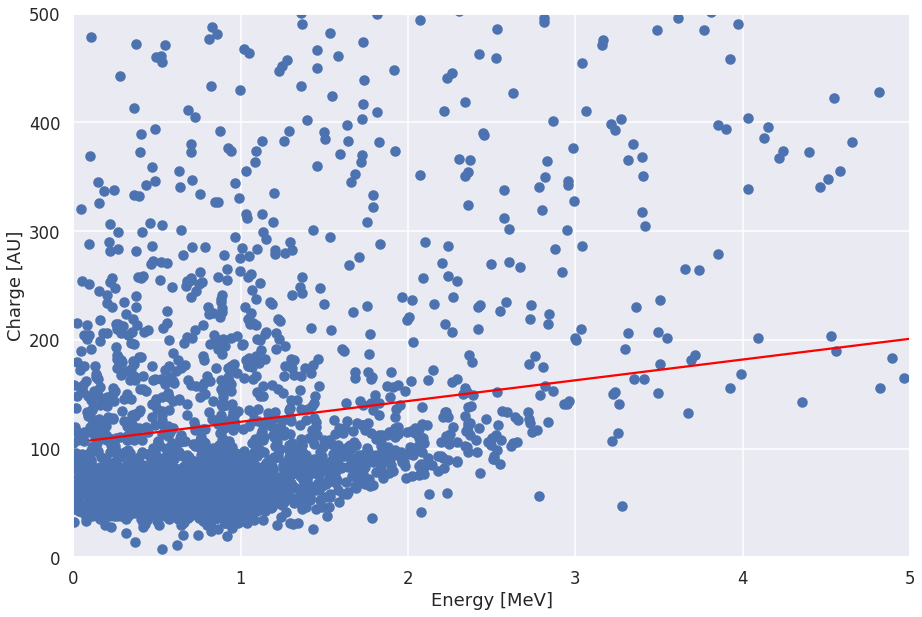

In [10]:
from matplotlib import pyplot as plt
import seaborn

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk') # or paper

plt.scatter(energies, charges)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 5)
plt.ylim(0, 500)
plt.xlabel('Energy [MeV]')
plt.ylabel('Charge [AU]')

m, y = np.polyfit(energies, charges, 1)
print('Slope:', m)

x = np.arange(0.1, 100, 0.1)
y = m*x+y
plt.plot(x, y, color='red')

plt.show()

Here we try a different scheme where we ignore the calorimetric information of the detector when it comes to showers and only use the amount of voxels reconstructed. We take a look at:
1. the amount of voxels reconstructed for a given amount of true shower voxels
2. the amount of voxels reconstructed for a given total energy deposition

In [5]:
import numpy as np

# Initialize a torch loader again
data_iterator = iter(hs.data_io)

n_events = len(hs.data_io)
print('N events:', n_events)
n_true = []
n_reco = []
voxel_energy = []
true_energy = []
#for i in range(100):
for i in range(n_events):
    event = next(data_iterator)
    true_mask = np.where(event['segment_label_true'][:,-1] == 2)[0]
    reco_mask = np.where(event['segment_label_reco'][:,-1] == 2)[0]
    n_true.append(len(true_mask))
    n_reco.append(len(reco_mask))
    voxel_energy.append(np.sum(event['energy'][:,-1][true_mask]))
    true_e = 0.
    for p in event['particles'][0]:
        if p.pdg_code() == 22 or abs(p.pdg_code()) == 11:
            true_e += p.energy_init()
    true_energy.append(true_e)

N events: 18044


Slope: 0.3005413803120636


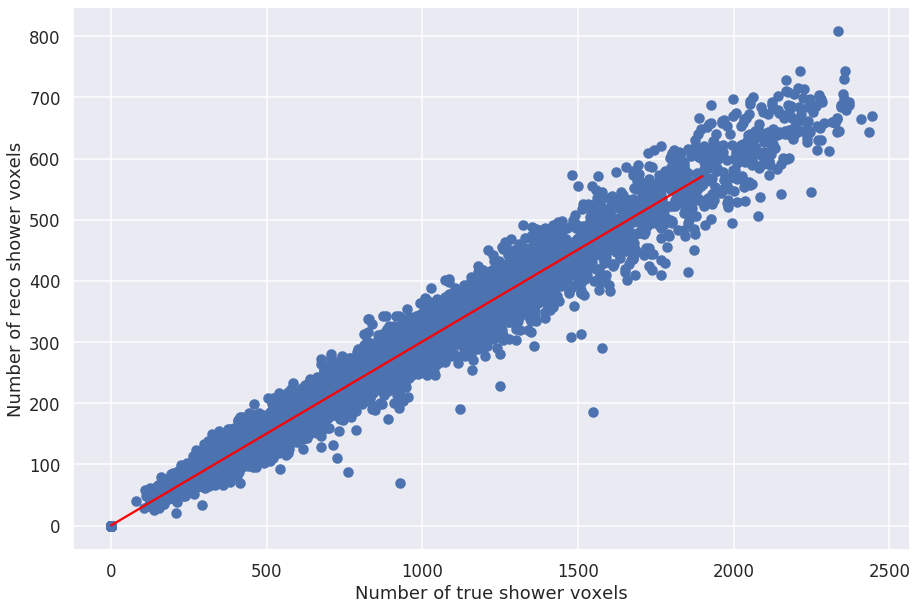

In [6]:
from matplotlib import pyplot as plt
import seaborn

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk') # or paper

plt.scatter(n_true, n_reco)
plt.xlabel('Number of true shower voxels')
plt.ylabel('Number of reco shower voxels')

m, y = np.polyfit(n_true, n_reco, 1)
print('Slope:', m)

x = np.arange(0, 2000, 100)
y = m*x+y
plt.plot(x, y, color='red')

plt.show()

Slope: 0.41469764342266485


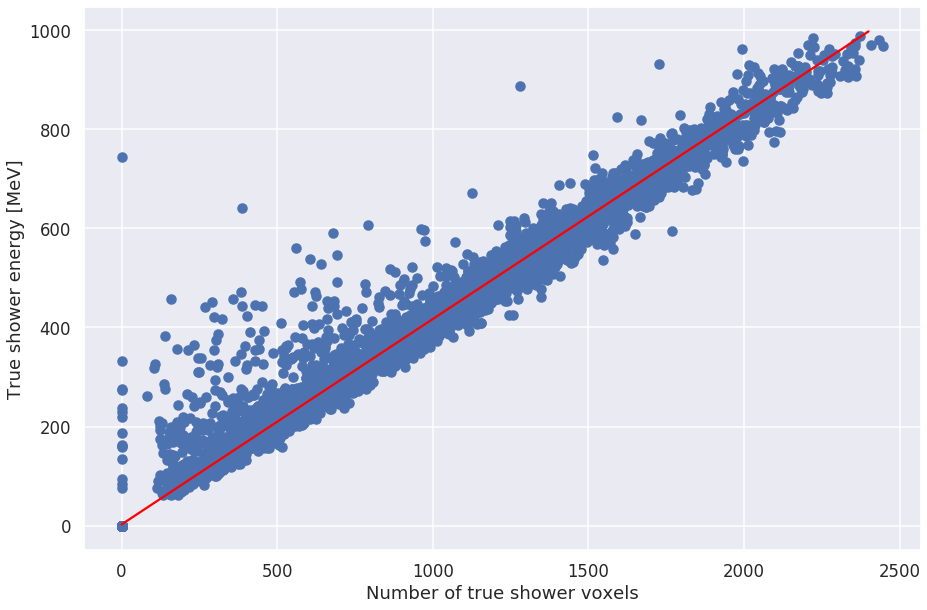

In [7]:
from matplotlib import pyplot as plt
import seaborn

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk') # or paper

plt.scatter(n_true, true_energy)
plt.xlabel('Number of true shower voxels')
plt.ylabel('True shower energy [MeV]')

m, y = np.polyfit(n_true, true_energy, 1)
print('Slope:', m)

x = np.arange(0, 2500, 100)
y = m*x+y
plt.plot(x, y, color='red')

plt.show()

Slope: 1.3692711531117354


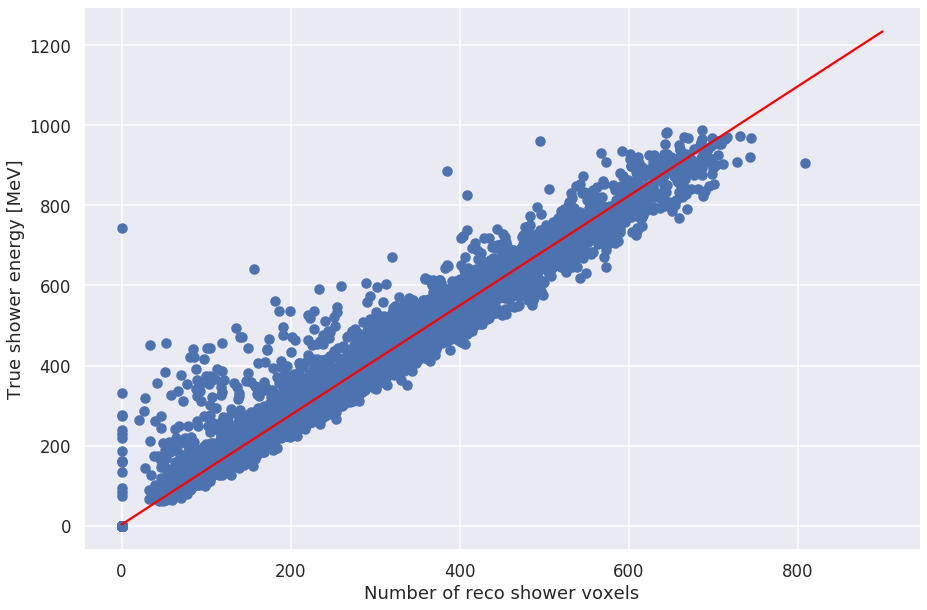

In [8]:
from matplotlib import pyplot as plt
import seaborn

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk') # or paper

plt.scatter(n_reco, true_energy)
plt.xlabel('Number of reco shower voxels')
plt.ylabel('True shower energy [MeV]')

m, y = np.polyfit(n_reco, true_energy, 1)
print('Slope:', m)

x = np.arange(0, 1000, 100)
y = m*x+y
plt.plot(x, y, color='red')

plt.show()

Slope: 0.9805962525584973


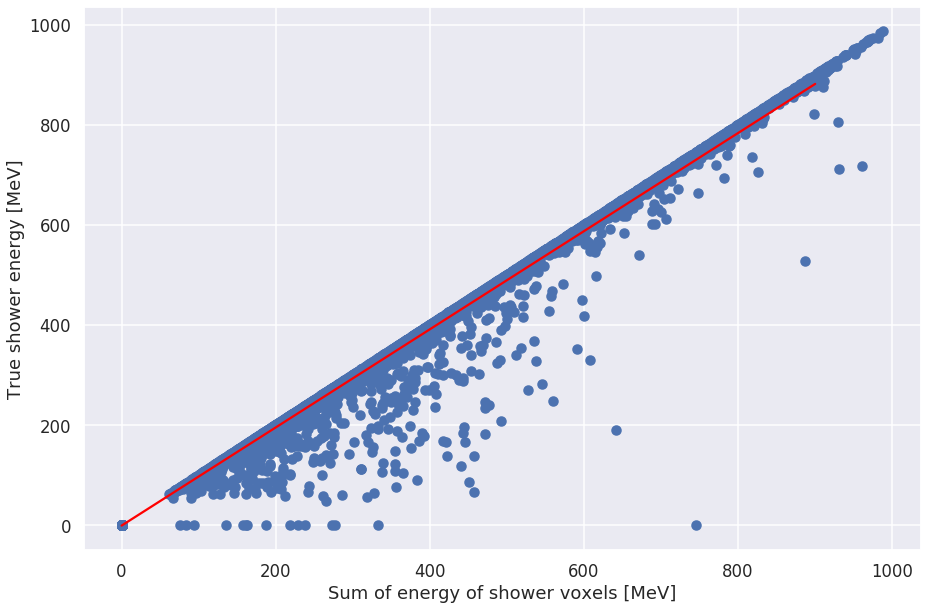

In [9]:
from matplotlib import pyplot as plt
import seaborn

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk') # or paper

plt.scatter(true_energy, voxel_energy)
plt.xlabel('Sum of energy of shower voxels [MeV]')
plt.ylabel('True shower energy [MeV]')

m, y = np.polyfit(true_energy, voxel_energy, 1)
print('Slope:', m)

x = np.arange(0, 1000, 100)
y = m*x+y
plt.plot(x, y, color='red')

plt.show()